# Анализ и составление рекомендательной модели на основе топ 270 книг по программированию и компьютерным наукам.

Данные: https://www.kaggle.com/thomaskonstantin/top-270-rated-computer-science-programing-books 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('prog_book.csv')
df.head()

,Rating,Reviews,Book_title,Description,Number_Of_Pages,Type,Price
0,4.17,"3,829",The Elements of Style,This style manual offers practical advice on i...,105,Hardcover,9.323529
1,4.01,"1,406","The Information: A History, a Theory, a Flood","James Gleick, the author of the best sellers C...",527,Hardcover,11.000000
2,3.33,0,Responsive Web Design Overview For Beginners,In Responsive Web Design Overview For Beginner...,50,Kindle Edition,11.267647
3,3.97,"1,658",Ghost in the Wires: My Adventures as the World...,If they were a hall of fame or shame for compu...,393,Hardcover,12.873529
4,4.06,"1,325",How Google Works,Both Eric Schmidt and Jonathan Rosenberg came ...,305,Kindle Edition,13.164706


In [21]:
df['Reviews'] = df['Reviews'].apply(lambda x : int(x.replace(',','')))

# Визуализация:

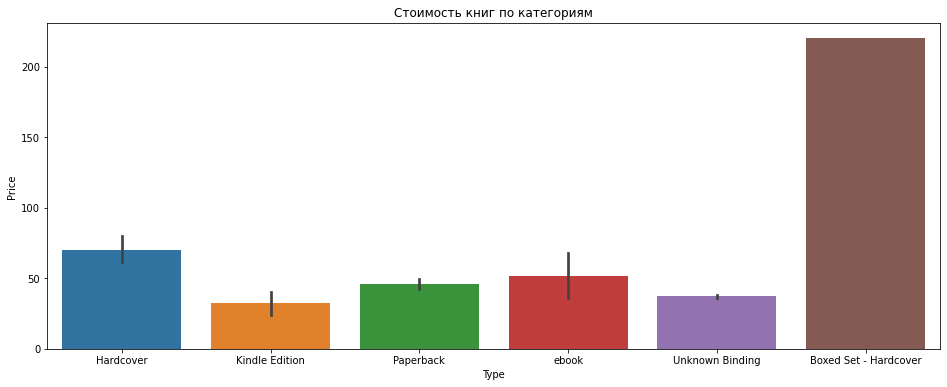

In [37]:
plt.figure(figsize=(16,6))
plt.title('Стоимость книг по категориям')

sns.barplot(x = 'Type',y = 'Price', data = df)
pass

### Вывод: книги в твердом переплете в коробках — самые дорогие, что в целом очевидно.

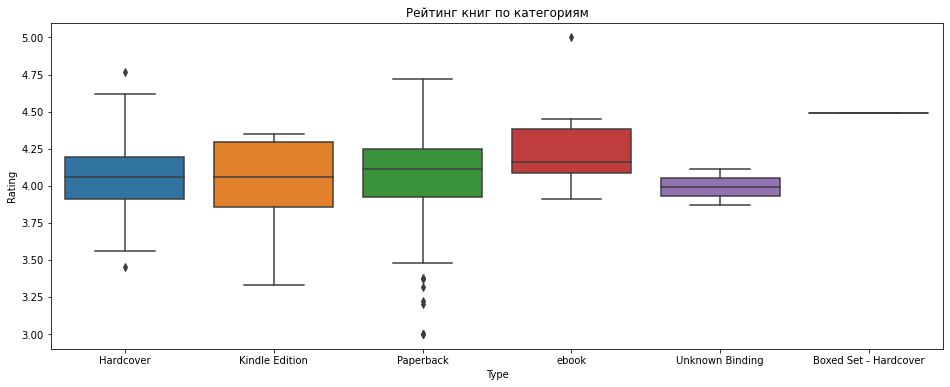

In [39]:
plt.figure(figsize=(16,6))
plt.title('Рейтинг книг по категориям')

sns.boxplot(x = 'Type',y = 'Rating',data = df)
pass

### Вывод: рейтинг книг по категориям в среднем находится в пределах 4 - 4.25. У Ebook сегмента сильное смещение среднего значения.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


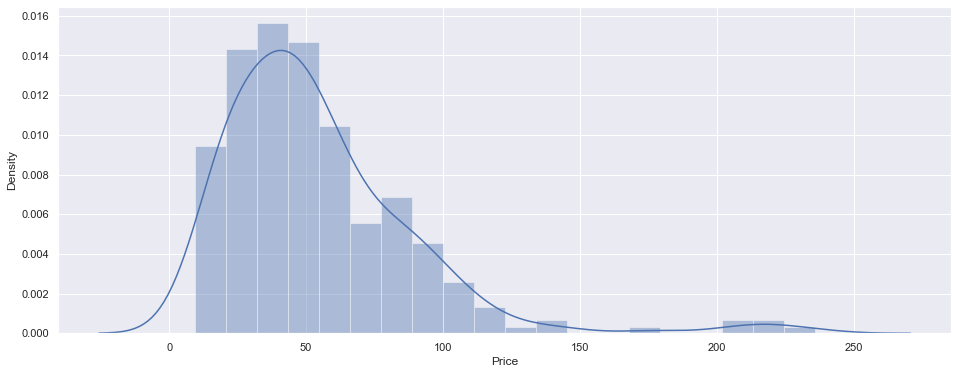

In [47]:
sns.set(rc={'figure.figsize':(16,6)})
sns.distplot(df['Price'])
pass

Видим, что средняя цена книг находится в пределах 50$.

# Посмотрим на корреляцию:

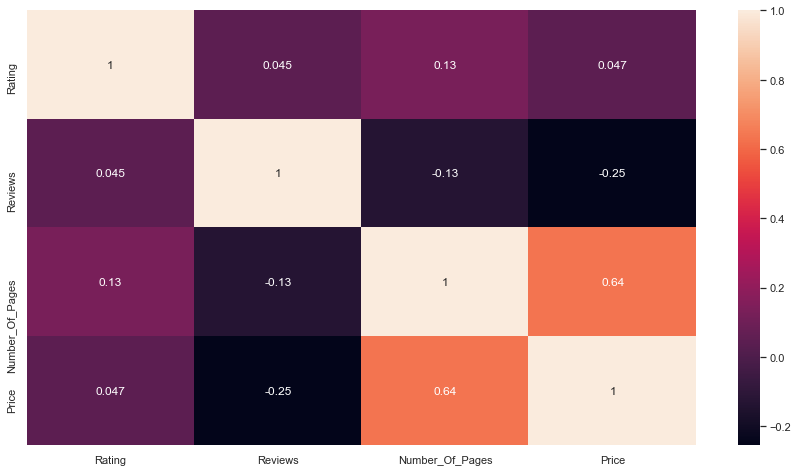

In [51]:
corr_matrix = df[list(df.columns)].corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_matrix, annot=True)
pass

Видим, что количество сраниц сильно скоррелированно с ценой изделия, что также логично.

# Переходим к составлению рекомендательной модели:

###  Будем использовать колонки "Book_title" и "Description", чтобы найти книги, похожие друг на друга

# Преобразование текста:

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = set(stop)
from string import punctuation

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import re

def lower(text):
    return text.lower()

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_digits(text):
    return re.sub(r'\d+', '', text)

def clean_text(text):
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    return text

## Создаем новые колонки с преобразованными "Book_title" и "Description":

In [5]:
df['clean_Book_title'] = df['Book_title'].apply(clean_text)
df['clean_Description']=df['Description'].apply(clean_text)
df.head() 

,Rating,Reviews,Book_title,Description,Number_Of_Pages,Type,Price,clean_Book_title,clean_Description
0,4.17,"3,829",The Elements of Style,This style manual offers practical advice on i...,105,Hardcover,9.323529,elements style,style manual offers practical advice improving...
1,4.01,"1,406","The Information: A History, a Theory, a Flood","James Gleick, the author of the best sellers C...",527,Hardcover,11.000000,information history theory flood,james gleick author best sellers chaos genius ...
2,3.33,0,Responsive Web Design Overview For Beginners,In Responsive Web Design Overview For Beginner...,50,Kindle Edition,11.267647,responsive web design overview beginners,responsive web design overview beginners youll...
3,3.97,"1,658",Ghost in the Wires: My Adventures as the World...,If they were a hall of fame or shame for compu...,393,Hardcover,12.873529,ghost wires adventures worlds wanted hacker,hall fame shame computer hackers kevin mitnick...
4,4.06,"1,325",How Google Works,Both Eric Schmidt and Jonathan Rosenberg came ...,305,Kindle Edition,13.164706,google works,eric schmidt jonathan rosenberg came google se...


# Создаем параметры модели: 

Делаем векторизацию

In [9]:
vectorizer = TfidfVectorizer(analyzer = 'word', lowercase=False)
X = vectorizer.fit_transform(df['clean_Book_title'])
title_vectors = X.toarray()
desc_vectorizer = TfidfVectorizer(analyzer='word', lowercase=False)
Y = desc_vectorizer.fit_transform(df['clean_Description'])
desc_vectors = Y.toarray()

# Строим рекомендательную систему:

In [10]:
def get_recommendations(value_of_element, feature_locate, df, vectors_array, feature_show):
    index_of_element = df[df[feature_locate]==value_of_element].index.values[0]
    show_value_of_element = df.iloc[index_of_element][feature_show]
    df_without = df.drop(index_of_element).reset_index().drop(['index'], axis=1)
    vectors_array = list(vectors_array)
    target = vectors_array.pop(index_of_element).reshape(1,-1)
    vectors_array = np.array(vectors_array)
    most_similar_sklearn = cosine_similarity(target, vectors_array)[0]
    idx = (-most_similar_sklearn).argsort()
    all_values = df_without[[feature_show]]
    for index in idx:
        simular = all_values.values[idx]
     
    recommendations_df = pd.DataFrame({feature_show: show_value_of_element,
                                    "rec_1": simular[0][0],
                                    "rec_2": simular[1][0],
                                    "rec_3": simular[2][0],
                                    "rec_4": simular[3][0],
                                    "rec_5": simular[4][0]}, index=[0])
    return recommendations_df

# Посмотрим на рекомендации книг по теме "Алгоритмы", опираясь на их название:

In [11]:
get_recommendations("Algorithms", 'Book_title', df, title_vectors, 'Book_title')

,Book_title,rec_1,rec_2,rec_3,rec_4,rec_5
0,Algorithms,Introduction to Algorithms,Algorithms Unlocked,Data Structures and Algorithms,Computational Geometry: Algorithms and Applica...,"The Art of Computer Programming, Volume 1: Fun..."


### Дополнительно посмотрим на их цену и рейтинг:

In [12]:
get_recommendations("Algorithms", 'Book_title', df, title_vectors, 'Price')

,Price,rec_1,rec_2,rec_3,rec_4,rec_5
0,78.608824,92.255882,34.355882,53.173529,52.038235,93.455882


In [13]:
get_recommendations("Algorithms", 'Book_title', df, title_vectors, 'Rating')

,Rating,rec_1,rec_2,rec_3,rec_4,rec_5
0,4.41,4.33,4.16,3.93,4.12,4.37


# Посмотрим на рекомендации книг по теме "Алгоритмы", опираясь на их описание:

In [14]:
get_recommendations("Algorithms", 'Book_title', df, desc_vectors, 'Book_title')

,Book_title,rec_1,rec_2,rec_3,rec_4,rec_5
0,Algorithms,Data Structures and Algorithms,Mining of Massive Datasets,Database System Concepts,Introduction to Algorithms,Algorithm Design


### Вывод: Можно видеть, что рекомендации, построенные по описанию и по названию отличаются. Посмотрим, два этих подхода на другой теме. 

In [15]:
get_recommendations("Unity in Action", 'Book_title', df, desc_vectors, 'Book_title')

,Book_title,rec_1,rec_2,rec_3,rec_4,rec_5
0,Unity in Action,Building an FPS Game with Unity,Unity Virtual Reality Projects,Coding Games in Scratch,"Introduction to Game Design, Prototyping, and ...",Game Programming Gems 4


In [16]:
get_recommendations("Unity in Action", 'Book_title', df, title_vectors, 'Book_title')

,Book_title,rec_1,rec_2,rec_3,rec_4,rec_5
0,Unity in Action,Building an FPS Game with Unity,Unity Virtual Reality Projects,Start with Why: How Great Leaders Inspire Ever...,"Introduction to Game Design, Prototyping, and ...",The Elements of Style


# Также мы можем получить доступ к книгам по какому-то уникальному значению, например, по количеству отзывов и по ID книги:

In [17]:
get_recommendations("1,406", 'Reviews',  df, title_vectors, 'Book_title')

,Book_title,rec_1,rec_2,rec_3,rec_4,rec_5
0,"The Information: A History, a Theory, a Flood",Introduction to the Theory of Computation,The Visual Display of Quantitative Information,Elements of the Theory of Computation,A First Course in Logic: An Introduction to Mo...,Basic Proof Theory


In [18]:
get_recommendations("The Information: A History, a Theory, a Flood", 'Book_title', df, title_vectors, 'Book_title')

,Book_title,rec_1,rec_2,rec_3,rec_4,rec_5
0,"The Information: A History, a Theory, a Flood",Introduction to the Theory of Computation,The Visual Display of Quantitative Information,Elements of the Theory of Computation,A First Course in Logic: An Introduction to Mo...,Basic Proof Theory
